<a href="https://colab.research.google.com/github/udaykarthik4245/t2_all/blob/main/Av_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy scikit-learn xgboost lightgbm seaborn matplotlib jupyterlab holidays skopt


  Using cached jupyterlab-4.4.3-py3-none-any.whl.metadata (16 kB)
ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 20.5 MB/s eta 0:00:00


LIBRARY IMPORTS HERE

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Booking_hackathon/utils')
from helpers import load_data
train, test, transactions = load_data('/content/drive/MyDrive/Booking_hackathon/data')


In [6]:
print(train.shape)
print(train.head())
print(train.info())
print(train.columns)

print(transactions.shape)
print(transactions.head())
print(transactions.info())
print(transactions.columns)

print(test.shape)
print(test.head())
print(test.columns)

(67200, 4)
          doj  srcid  destid  final_seatcount
0  2023-03-01     45      46           2838.0
1  2023-03-01     46      45           2298.0
2  2023-03-01     45      47           2720.0
3  2023-03-01     47      45           2580.0
4  2023-03-01     46       9           4185.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67200 entries, 0 to 67199
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   doj              67200 non-null  object 
 1   srcid            67200 non-null  int64  
 2   destid           67200 non-null  int64  
 3   final_seatcount  67200 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.1+ MB
None
Index(['doj', 'srcid', 'destid', 'final_seatcount'], dtype='object')
(2266100, 11)
          doj         doi  srcid  destid    srcid_region   destid_region  \
0  2023-03-01  2023-01-30     45      46       Karnataka      Tamil Nadu   
1  2023-03-01  2023-01-30  

CHECK FOR MISSING VALUES


In [7]:
print(train.isnull().sum())
print(transactions.isnull().sum())


doj                0
srcid              0
destid             0
final_seatcount    0
dtype: int64
doj                   0
doi                   0
srcid                 0
destid                0
srcid_region          0
destid_region         0
srcid_tier            0
destid_tier           0
cumsum_seatcount      0
cumsum_searchcount    0
dbd                   0
dtype: int64


Understand Target Distribution

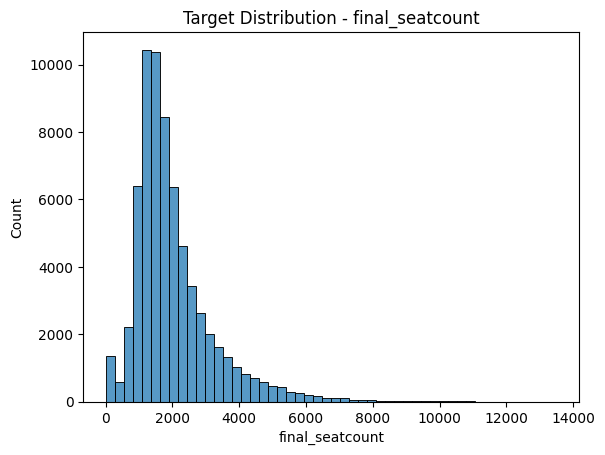

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train['final_seatcount'], bins=50)
plt.title("Target Distribution - final_seatcount")
plt.show()


In [13]:
# Preview Unique Journey Routes and Dates
'''This code snippet first prints the number of unique values
for srcid and destid columns in the train dataframe using .nunique().
This helps understand the number of unique source and destination locations in the training data.
Then it prints the minimum and maximum dates in the doj column
of the train dataframe using .min() and .max(), respectively, to show the date range covered by the training data.'''

print(train[['srcid', 'destid']].nunique())
print('----------------------')
print(train['doj'].min(),'min<--||-->max', train['doj'].max())

srcid     45
destid    45
dtype: int64
----------------------
2023-03-01 min<--||-->max 2024-12-31


<Axes: xlabel='dbd'>

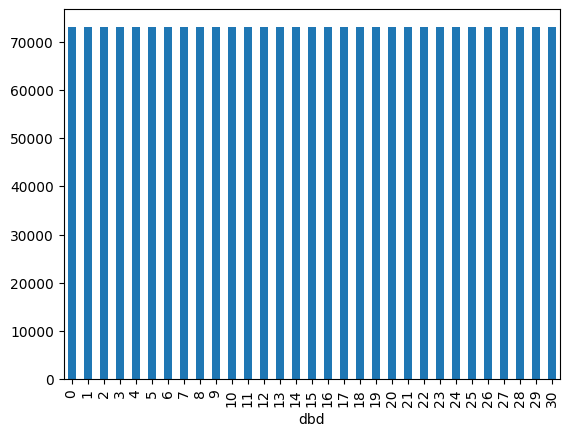

In [15]:
'''Check how dbd ranges are distributed
Plot average cumsum_seatcount and cumsum_searchcount by dbd'''


transactions['dbd'].value_counts().sort_index().plot(kind='bar')


In [17]:
# 1. Convert date columns to datetime
for df in [train, test, transactions]:
    df['doj'] = pd.to_datetime(df['doj'])
transactions['doi'] = pd.to_datetime(transactions['doi'])


In [20]:
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266100 entries, 0 to 2266099
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   doj                 datetime64[ns]
 1   doi                 datetime64[ns]
 2   srcid               int64         
 3   destid              int64         
 4   srcid_region        object        
 5   destid_region       object        
 6   srcid_tier          object        
 7   destid_tier         object        
 8   cumsum_seatcount    float64       
 9   cumsum_searchcount  float64       
 10  dbd                 int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(4)
memory usage: 190.2+ MB
None


In [21]:
# 2. Filter transactions where dbd == 15
trans_15 = transactions[transactions['dbd'] == 15].copy()

In [23]:
print(trans_15.count())

doj                   73100
doi                   73100
srcid                 73100
destid                73100
srcid_region          73100
destid_region         73100
srcid_tier            73100
destid_tier           73100
cumsum_seatcount      73100
cumsum_searchcount    73100
dbd                   73100
dtype: int64


In [24]:
# 3. Prepare for merging: select only useful columns
feature_cols = [
    'doj', 'srcid', 'destid',
    'cumsum_seatcount', 'cumsum_searchcount',
    'srcid_region', 'destid_region',
    'srcid_tier', 'destid_tier'
]
trans_15 = trans_15[feature_cols]

In [25]:
train_merged = pd.merge(train, trans_15, on=['doj', 'srcid', 'destid'], how='left')

In [26]:
# 4. Merge with train data
print(train_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67200 entries, 0 to 67199
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   doj                 67200 non-null  datetime64[ns]
 1   srcid               67200 non-null  int64         
 2   destid              67200 non-null  int64         
 3   final_seatcount     67200 non-null  float64       
 4   cumsum_seatcount    67200 non-null  float64       
 5   cumsum_searchcount  67200 non-null  float64       
 6   srcid_region        67200 non-null  object        
 7   destid_region       67200 non-null  object        
 8   srcid_tier          67200 non-null  object        
 9   destid_tier         67200 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 5.1+ MB
None


In [27]:

# 5. Merge with test data
test_merged = pd.merge(test, trans_15, on=['doj', 'srcid', 'destid'], how='left')
print(test_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   route_key           5900 non-null   object        
 1   doj                 5900 non-null   datetime64[ns]
 2   srcid               5900 non-null   int64         
 3   destid              5900 non-null   int64         
 4   cumsum_seatcount    5900 non-null   float64       
 5   cumsum_searchcount  5900 non-null   float64       
 6   srcid_region        5900 non-null   object        
 7   destid_region       5900 non-null   object        
 8   srcid_tier          5900 non-null   object        
 9   destid_tier         5900 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 461.1+ KB
None


In [28]:
print(train.shape == train_merged.shape)

False


In [29]:
# Compare number of rows before and after merge
print(f"Original Train Rows: {train.shape[0]}")
print(f"Merged Train Rows: {train_merged.shape[0]}")
print(f"Original Test Rows: {test.shape[0]}")
print(f"Merged Test Rows: {test_merged.shape[0]}")


Original Train Rows: 67200
Merged Train Rows: 67200
Original Test Rows: 5900
Merged Test Rows: 5900


In [30]:
# Count missing values in new features (after merge)
print(train_merged.isnull().sum())
print(test_merged.isnull().sum())


doj                   0
srcid                 0
destid                0
final_seatcount       0
cumsum_seatcount      0
cumsum_searchcount    0
srcid_region          0
destid_region         0
srcid_tier            0
destid_tier           0
dtype: int64
route_key             0
doj                   0
srcid                 0
destid                0
cumsum_seatcount      0
cumsum_searchcount    0
srcid_region          0
destid_region         0
srcid_tier            0
destid_tier           0
dtype: int64


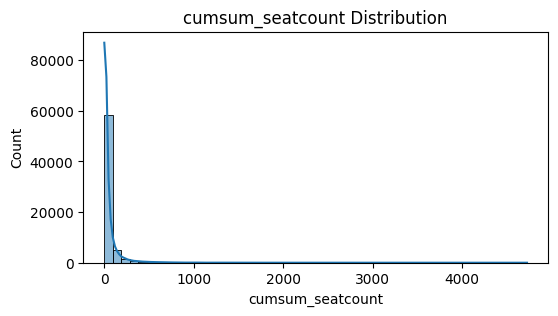

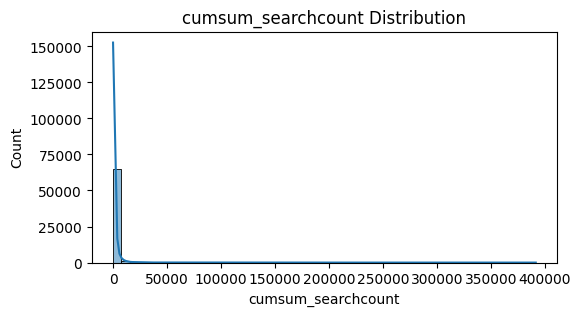

In [31]:
#Check if any feature is suspiciously skewed, has constant values, or has obvious leakage patterns.
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms for new features
features = ['cumsum_seatcount', 'cumsum_searchcount']
for col in features:
    plt.figure(figsize=(6, 3))
    sns.histplot(train_merged[col], bins=50, kde=True)
    plt.title(f"{col} Distribution")
    plt.show()


In [38]:
# 1. Apply Log Transformation to Skewed Feature

import numpy as np

train_merged['log_cumsum_searchcount'] = np.log1p(train_merged['cumsum_searchcount'])
test_merged['log_cumsum_searchcount'] = np.log1p(test_merged['cumsum_searchcount'])

train_merged['log_cumsum_seatcount'] = np.log1p(train_merged['cumsum_seatcount'])
test_merged['log_cumsum_seatcount'] = np.log1p(test_merged['cumsum_seatcount'])

In [39]:
# 2. Time-Based Features
train_merged['day_of_week'] = train_merged['doj'].dt.dayofweek
test_merged['day_of_week'] = test_merged['doj'].dt.dayofweek

train_merged['month'] = train_merged['doj'].dt.month
test_merged['month'] = test_merged['doj'].dt.month

train_merged['is_weekend'] = train_merged['day_of_week'].isin([5, 6]).astype(int)
test_merged['is_weekend'] = test_merged['day_of_week'].isin([5, 6]).astype(int)

In [40]:
#  Categorical Encoding (Regions, Tiers)
# Use Label Encoding or leave them as strings for CatBoost. For LightGBM, you can do label encoding:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']
le = LabelEncoder()
for col in cat_cols:
    train_merged[col] = le.fit_transform(train_merged[col])
    test_merged[col] = le.transform(test_merged[col])


In [41]:
features = [
    'log_cumsum_searchcount', 'log_cumsum_seatcount',
    'day_of_week', 'month', 'is_weekend',
    'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier'
]


ANALYZING ABOVE FOR SKEWNESS

<Axes: xlabel='log_cumsum_searchcount', ylabel='Count'>

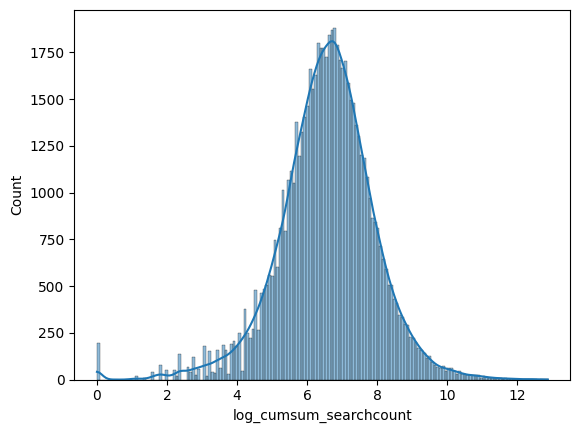

In [43]:
# 1. Feature Distributions After Transformation
# Check that log_cumsum_* features are now more normally distributed.

import seaborn as sns
sns.histplot(train_merged['log_cumsum_searchcount'], kde=True)



<Axes: xlabel='log_cumsum_seatcount', ylabel='Count'>

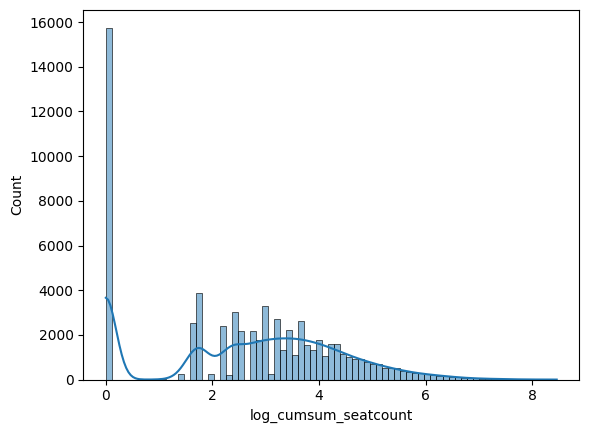

In [44]:
sns.histplot(train_merged['log_cumsum_seatcount'], kde=True)
# ✅ Expected: Bell-shaped or less skewed curves than before.

In [45]:
# Categorical Feature Sanity
# Confirm label encodings are successful and unique mappings are reasonable.


for col in cat_cols:
    print(f"{col} unique values:", train_merged[col].nunique())
# ✅ Expected: Number of classes matches expectations (~few regions/tiers, no sudden inflation).

srcid_region unique values: 10
destid_region unique values: 10
srcid_tier unique values: 4
destid_tier unique values: 4


In [46]:
#  Correlation With Target (Optional Insight)
# Use .corr() to see how numeric features correlate with final_seatcount.


print(train_merged[features + ['final_seatcount']].corr()['final_seatcount'].sort_values(ascending=False))
# ✅ Expected: log_cumsum_seatcount and log_cumsum_searchcount should show positive correlation.



final_seatcount           1.000000
log_cumsum_searchcount    0.617418
log_cumsum_seatcount      0.537394
day_of_week               0.148771
is_weekend                0.128512
destid_region             0.123752
srcid_region              0.120402
month                     0.055128
destid_tier              -0.069496
srcid_tier               -0.073298
Name: final_seatcount, dtype: float64


In [48]:
#  Check for Constant or Near-Constant Columns
# These provide no useful signal and should be removed.

print(train_merged[features].nunique().sort_values())
# ✅ Expected: No columns with only 1 or 2 unique values unless intentional (like is_weekend).

is_weekend                   2
srcid_tier                   4
destid_tier                  4
day_of_week                  7
destid_region               10
srcid_region                10
month                       12
log_cumsum_seatcount       737
log_cumsum_searchcount    6112
dtype: int64


AFTER ANALYZATION ADDING THE BINARY FLAGS

In [49]:
# 💡 Your idea is spot on: Add binary flags to indicate presence/absence of early signals.

train_merged['has_search'] = (train_merged['cumsum_searchcount'] > 0).astype(int)
test_merged['has_search'] = (test_merged['cumsum_searchcount'] > 0).astype(int)

train_merged['has_seats'] = (train_merged['cumsum_seatcount'] > 0).astype(int)
test_merged['has_seats'] = (test_merged['cumsum_seatcount'] > 0).astype(int)
# ✅ These binary indicators are especially useful for tree models to split on presence/absence.

In [50]:
# Define Feature Columns
# Include your engineered features:

features = [
    'log_cumsum_searchcount', 'log_cumsum_seatcount',
    'has_search', 'has_seats',
    'day_of_week', 'month', 'is_weekend',
    'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier'
]

In [52]:
# Train-Validation Split
# Use random split for now (or time-based if you want temporal validation):

from sklearn.model_selection import train_test_split

X = train_merged[features]
y = train_merged['final_seatcount']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

LIGHTGBM MODEL TRAINING

In [55]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import early_stopping, log_evaluation

model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)]
)


# Predict and Evaluate
y_pred = model.predict(X_val)
import numpy as np
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"Validation RMSE: {rmse:.4f}")

# rmse = mean_squared_error(y_val, y_pred, squared=False)
# print(f"Validation RMSE: {rmse:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 47040, number of used features: 11
[LightGBM] [Info] Start training from score 2002.141943
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 628.747	valid_0's l2: 395323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 591.447	valid_0's l2: 349810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [56]:
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 545.0564


In [61]:
!pip install scikit-learn-1.7.0

ERROR: Could not find a version that satisfies the requirement scikit-learn-1.7.0 (from versions: none)
ERROR: No matching distribution found for scikit-learn-1.7.0


DEFINE OBJECTIVES FOR OPTUNA
 Optuna Hyperparameter Tuning with LightGBM

In [62]:
import optuna
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Split to avoid data leakage
X = train_merged[features]
y = train_merged['final_seatcount']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        'random_state': 42
    }
    model = LGBMRegressor(**params)
    from lightgbm import log_evaluation

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[log_evaluation(0)]  # or use log_evaluation(100) for updates every 100 rounds
    )

    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
best_params = study.best_params
best_params.update({'n_estimators': 1000, 'random_state': 42})
print("Best tuning params:", best_params)

[I 2025-06-21 17:48:19,381] A new study created in memory with name: no-name-a7524d81-9d3d-42dc-8dca-f3ab4d0c1415


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:48:27,122] Trial 0 finished with value: 567.4347078327929 and parameters: {'learning_rate': 0.016539794297951556, 'max_depth': 6, 'num_leaves': 71, 'subsample': 0.8844326512923266, 'colsample_bytree': 0.8504417832696377, 'min_child_samples': 50}. Best is trial 0 with value: 567.4347078327929.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:48:35,156] Trial 1 finished with value: 544.4645887454935 and parameters: {'learning_rate': 0.021585267744881856, 'max_depth': 10, 'num_leaves': 56, 'subsample': 0.7973079829209393, 'colsample_bytree': 0.7040504148446888, 'min_child_samples': 35}. Best is trial 1 with value: 544.4645887454935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:48:39,391] Trial 2 finished with value: 539.2593457122899 and parameters: {'learning_rate': 0.08223740563684259, 'max_depth': 8, 'num_leaves': 20, 'subsample': 0.7714392066077105, 'colsample_bytree': 0.705278408373219, 'min_child_samples': 26}. Best is trial 2 with value: 539.2593457122899.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:48:47,460] Trial 3 finished with value: 540.2464434393952 and parameters: {'learning_rate': 0.059154136720264684, 'max_depth': 7, 'num_leaves': 84, 'subsample': 0.7017043718838024, 'colsample_bytree': 0.8076381495649269, 'min_child_samples': 29}. Best is trial 2 with value: 539.2593457122899.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:48:52,056] Trial 4 finished with value: 540.4097637346475 and parameters: {'learning_rate': 0.08679533337839901, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.8687031488356596, 'colsample_bytree': 0.8431148240742697, 'min_child_samples': 42}. Best is trial 2 with value: 539.2593457122899.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:48:59,806] Trial 5 finished with value: 542.2587309773639 and parameters: {'learning_rate': 0.06872374213249949, 'max_depth': 7, 'num_leaves': 59, 'subsample': 0.8665915326923999, 'colsample_bytree': 0.8012380614482665, 'min_child_samples': 46}. Best is trial 2 with value: 539.2593457122899.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:49:06,086] Trial 6 finished with value: 539.0482513616627 and parameters: {'learning_rate': 0.05251685813803839, 'max_depth': 10, 'num_leaves': 47, 'subsample': 0.7035197616917255, 'colsample_bytree': 0.8545706561757521, 'min_child_samples': 37}. Best is trial 6 with value: 539.0482513616627.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:49:14,390] Trial 7 finished with value: 542.4379349138899 and parameters: {'learning_rate': 0.021194833219217706, 'max_depth': 10, 'num_leaves': 63, 'subsample': 0.8313972860927694, 'colsample_bytree': 0.751022812953853, 'min_child_samples': 31}. Best is trial 6 with value: 539.0482513616627.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:49:25,060] Trial 8 finished with value: 544.8980341280551 and parameters: {'learning_rate': 0.01806224561588492, 'max_depth': 8, 'num_leaves': 88, 'subsample': 0.8066351000082407, 'colsample_bytree': 0.7071312606692869, 'min_child_samples': 21}. Best is trial 6 with value: 539.0482513616627.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533


[I 2025-06-21 17:49:29,923] Trial 9 finished with value: 551.8935616362184 and parameters: {'learning_rate': 0.0345209342496655, 'max_depth': 8, 'num_leaves': 22, 'subsample': 0.8682656027380933, 'colsample_bytree': 0.7542372464980159, 'min_child_samples': 29}. Best is trial 6 with value: 539.0482513616627.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:49:37,135] Trial 10 finished with value: 541.8093899291741 and parameters: {'learning_rate': 0.04537100490843595, 'max_depth': 9, 'num_leaves': 42, 'subsample': 0.71045242294732, 'colsample_bytree': 0.8933024393183764, 'min_child_samples': 40}. Best is trial 6 with value: 539.0482513616627.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:49:42,517] Trial 11 finished with value: 540.1708176874254 and parameters: {'learning_rate': 0.09862302076371333, 'max_depth': 9, 'num_leaves': 39, 'subsample': 0.7466139541802281, 'colsample_bytree': 0.8941184288152286, 'min_child_samples': 22}. Best is trial 6 with value: 539.0482513616627.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:49:48,668] Trial 12 finished with value: 537.9439280495855 and parameters: {'learning_rate': 0.07356899272123285, 'max_depth': 7, 'num_leaves': 38, 'subsample': 0.7490828850376051, 'colsample_bytree': 0.8453095456242061, 'min_child_samples': 35}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:49:55,245] Trial 13 finished with value: 540.3276314762188 and parameters: {'learning_rate': 0.06803278378422678, 'max_depth': 6, 'num_leaves': 41, 'subsample': 0.7354945816046242, 'colsample_bytree': 0.8527664390577967, 'min_child_samples': 36}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:50:01,391] Trial 14 finished with value: 542.8603286830661 and parameters: {'learning_rate': 0.0474788872393733, 'max_depth': 7, 'num_leaves': 35, 'subsample': 0.7397853522132307, 'colsample_bytree': 0.8317979351992827, 'min_child_samples': 37}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-06-21 17:50:08,863] Trial 15 finished with value: 538.5332815537662 and parameters: {'learning_rate': 0.06576926492128272, 'max_depth': 10, 'num_leaves': 51, 'subsample': 0.7597893012680584, 'colsample_bytree': 0.87335023098853, 'min_child_samples': 33}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:50:16,480] Trial 16 finished with value: 538.5992873824914 and parameters: {'learning_rate': 0.07799222689143054, 'max_depth': 7, 'num_leaves': 73, 'subsample': 0.7748059367607674, 'colsample_bytree': 0.8756442538981266, 'min_child_samples': 33}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:50:22,230] Trial 17 finished with value: 542.2715734682798 and parameters: {'learning_rate': 0.06517848233165355, 'max_depth': 9, 'num_leaves': 31, 'subsample': 0.7655960855497911, 'colsample_bytree': 0.823575120102326, 'min_child_samples': 41}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:50:28,604] Trial 18 finished with value: 539.9776294629548 and parameters: {'learning_rate': 0.09385427675809145, 'max_depth': 6, 'num_leaves': 49, 'subsample': 0.799611497074073, 'colsample_bytree': 0.7728856051494045, 'min_child_samples': 26}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-06-21 17:50:35,023] Trial 19 finished with value: 540.6567721595578 and parameters: {'learning_rate': 0.0769820505273248, 'max_depth': 7, 'num_leaves': 29, 'subsample': 0.7265186445865772, 'colsample_bytree': 0.8729894171683354, 'min_child_samples': 45}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:50:44,147] Trial 20 finished with value: 537.9784427964314 and parameters: {'learning_rate': 0.03581553015868839, 'max_depth': 8, 'num_leaves': 96, 'subsample': 0.7574794261826837, 'colsample_bytree': 0.8720954811780162, 'min_child_samples': 32}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:50:51,969] Trial 21 finished with value: 539.6243751254145 and parameters: {'learning_rate': 0.03470785291849152, 'max_depth': 8, 'num_leaves': 81, 'subsample': 0.7560072437858927, 'colsample_bytree': 0.8737535144708366, 'min_child_samples': 33}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:51:01,198] Trial 22 finished with value: 540.3540829266167 and parameters: {'learning_rate': 0.036128352060962626, 'max_depth': 8, 'num_leaves': 93, 'subsample': 0.7846302474126093, 'colsample_bytree': 0.8722073609785254, 'min_child_samples': 32}. Best is trial 12 with value: 537.9439280495855.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:51:07,764] Trial 23 finished with value: 536.7494673693844 and parameters: {'learning_rate': 0.0581258213053735, 'max_depth': 8, 'num_leaves': 52, 'subsample': 0.7302143838380609, 'colsample_bytree': 0.823831531894042, 'min_child_samples': 27}. Best is trial 23 with value: 536.7494673693844.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:51:16,578] Trial 24 finished with value: 537.3766098313204 and parameters: {'learning_rate': 0.043159506127899434, 'max_depth': 8, 'num_leaves': 67, 'subsample': 0.7234898682263811, 'colsample_bytree': 0.8212675439301896, 'min_child_samples': 27}. Best is trial 23 with value: 536.7494673693844.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:51:24,682] Trial 25 finished with value: 537.3886583162401 and parameters: {'learning_rate': 0.0563850879715776, 'max_depth': 7, 'num_leaves': 68, 'subsample': 0.7250561778102107, 'colsample_bytree': 0.8170412993321637, 'min_child_samples': 24}. Best is trial 23 with value: 536.7494673693844.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:51:31,689] Trial 26 finished with value: 536.8810575318183 and parameters: {'learning_rate': 0.05745373699883068, 'max_depth': 8, 'num_leaves': 67, 'subsample': 0.7200835003528526, 'colsample_bytree': 0.7823485865977277, 'min_child_samples': 24}. Best is trial 23 with value: 536.7494673693844.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:51:40,393] Trial 27 finished with value: 537.909547044718 and parameters: {'learning_rate': 0.04452946417696628, 'max_depth': 9, 'num_leaves': 77, 'subsample': 0.7175400872799236, 'colsample_bytree': 0.7889466913465436, 'min_child_samples': 26}. Best is trial 23 with value: 536.7494673693844.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:51:48,062] Trial 28 finished with value: 539.5193200068243 and parameters: {'learning_rate': 0.027992999128508063, 'max_depth': 8, 'num_leaves': 63, 'subsample': 0.8245443075220322, 'colsample_bytree': 0.7844986948482887, 'min_child_samples': 23}. Best is trial 23 with value: 536.7494673693844.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 2003.632533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-21 17:51:56,301] Trial 29 finished with value: 537.040706168378 and parameters: {'learning_rate': 0.05210234246858463, 'max_depth': 8, 'num_leaves': 68, 'subsample': 0.7175965698717873, 'colsample_bytree': 0.7634338078821606, 'min_child_samples': 20}. Best is trial 23 with value: 536.7494673693844.


Best tuning params: {'learning_rate': 0.0581258213053735, 'max_depth': 8, 'num_leaves': 52, 'subsample': 0.7302143838380609, 'colsample_bytree': 0.823831531894042, 'min_child_samples': 27, 'n_estimators': 1000, 'random_state': 42}


 #Trial 29 finished with value: 537.040706168378 and parameters: {'learning_rate': 0.05210234246858463, 'max_depth': 8, 'num_leaves': 68, 'subsample': 0.7175965698717873, 'colsample_bytree': 0.7634338078821606, 'min_child_samples': 20}. Best is trial 23 with value: 536.7494673693844.
Best tuning params: {'learning_rate': 0.0581258213053735, 'max_depth': 8, 'num_leaves': 52, 'subsample': 0.7302143838380609, 'colsample_bytree': 0.823831531894042, 'min_child_samples': 27, 'n_estimators': 1000, 'random_state': 42}

In [64]:
# . Add Route-Level Demand Feature

route_avg = train.groupby(['srcid', 'destid'])['final_seatcount'].mean().reset_index()
route_avg.rename(columns={'final_seatcount': 'route_avg_seats'}, inplace=True)
for df in [train_merged, test_merged]:
    # Remove inplace=True and reassign the result
    if df is train_merged:
        train_merged = df.merge(route_avg, on=['srcid', 'destid'], how='left')
    elif df is test_merged:
        test_merged = df.merge(route_avg, on=['srcid', 'destid'], how='left')

features.append('route_avg_seats')

In [65]:
print(features)

['log_cumsum_searchcount', 'log_cumsum_seatcount', 'has_search', 'has_seats', 'day_of_week', 'month', 'is_weekend', 'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier', 'route_avg_seats']


In [66]:
# Public-Holiday Indicator Feature

from holidays import India
india_holidays = set(India(years=[2023, 2024, 2025]).keys())

for df in [train_merged, test_merged]:
    df['is_holiday'] = df['doj'].dt.date.isin(india_holidays).astype(int)
features.append('is_holiday')

In [67]:
print(features)

['log_cumsum_searchcount', 'log_cumsum_seatcount', 'has_search', 'has_seats', 'day_of_week', 'month', 'is_weekend', 'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier', 'route_avg_seats', 'is_holiday']


4. Clip Target to Handle Extreme Outliers

In [68]:
y_train_clipped = y_train.clip(0, y_train.quantile(0.99))

In [69]:
print(y_train_clipped)

39801    3330.0
9785     1715.0
7760     2255.0
675      2180.0
26239    1896.0
          ...  
37194    1015.0
6265     1835.0
54886    1835.0
860      1305.0
15795    1175.0
Name: final_seatcount, Length: 53760, dtype: float64


 Train the Final Model With Best Parameters

In [71]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping, log_evaluation
import numpy as np

final_model = LGBMRegressor(**best_params)
final_model.fit(X_train, y_train_clipped,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                callbacks=[
                    early_stopping(stopping_rounds=50),
                    log_evaluation(period=100)
                ])
val_preds = final_model.predict(X_val)

final_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"Final Validation RMSE: {final_rmse:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 53760, number of used features: 11
[LightGBM] [Info] Start training from score 1991.975335
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 608.418	valid_0's l2: 370173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

Recommended Next Steps
Run the CatBoost model with same features and training data.

Average predictions with LightGBM.

Recalculate RMSE to see if you're closer to your target.

*** 1: Train CatBoost on the Same Data ***

In [72]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [73]:
# Step 1: Train CatBoost on the Same Data

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Train CatBoost on clipped target for consistency
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    verbose=100,
    loss_function='RMSE'
)

cat_model.fit(X_train, y_train_clipped, eval_set=(X_val, y_val), use_best_model=True)

0:	learn: 1110.2887446	test: 1171.6202966	best: 1171.6202966 (0)	total: 110ms	remaining: 1m 49s
100:	learn: 613.5189619	test: 653.1077174	best: 653.1077174 (100)	total: 3.12s	remaining: 27.7s
200:	learn: 566.7048460	test: 604.6125036	best: 604.6125036 (200)	total: 7.7s	remaining: 30.6s
300:	learn: 547.2511005	test: 587.4717331	best: 587.4717331 (300)	total: 10.5s	remaining: 24.4s
400:	learn: 532.9339808	test: 576.1609097	best: 576.1609097 (400)	total: 13.2s	remaining: 19.6s
500:	learn: 521.1417480	test: 568.0371496	best: 568.0371496 (500)	total: 14.1s	remaining: 14.1s
600:	learn: 510.9227853	test: 561.8914032	best: 561.8914032 (600)	total: 15.1s	remaining: 10s
700:	learn: 502.6332228	test: 557.0609687	best: 557.0576242 (699)	total: 16.1s	remaining: 6.88s
800:	learn: 495.3571804	test: 553.5595953	best: 553.5595953 (800)	total: 17.3s	remaining: 4.3s
900:	learn: 488.6962842	test: 550.7358908	best: 550.7358908 (900)	total: 20s	remaining: 2.19s
999:	learn: 482.6251075	test: 548.9233837	best

***Step 2: Make Predictions and Ensemble***



In [75]:
# Predictions from both models
lgb_preds = final_model.predict(X_val)
cat_preds = cat_model.predict(X_val)

# Ensemble (simple average)
ensemble_preds = (lgb_preds + cat_preds) / 2

# Evaluate RMSE
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_preds))
print(f"Ensemble Validation RMSE: {ensemble_rmse:.4f}")

Ensemble Validation RMSE: 544.1791


In [77]:
# Try 60% LGBM, 40% CatBoost
weighted_preds = 0.6 * lgb_preds + 0.4 * cat_preds
weighted_rmse = np.sqrt(mean_squared_error(y_val, weighted_preds))
print(f"Weighted Ensemble RMSE (60/40): {weighted_rmse:.4f}")

Weighted Ensemble RMSE (60/40): 544.2235


In [78]:
# Check columns in test
print(set(features).issubset(set(test_merged.columns)))  # should be True


True


In [80]:
print(final_model.feature_name_)


['log_cumsum_searchcount', 'log_cumsum_seatcount', 'has_search', 'has_seats', 'day_of_week', 'month', 'is_weekend', 'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']


In [81]:
features = final_model.feature_name_


In [82]:
# Predict using both models
lgb_test_preds = final_model.predict(test_merged[features])
cat_test_preds = cat_model.predict(test_merged[features])

# Final ensemble prediction (50/50)
final_test_preds = (lgb_test_preds + cat_test_preds) / 2


In [83]:
print(final_test_preds)

[3534.42250033 1572.57856889 1205.43912898 ... 2315.9315075  1316.53768307
 2380.46833037]


In [85]:
submission = test[['route_key']].copy()
submission['final_seatcount'] = final_test_preds
submission.to_csv("final_submission.csv", index=False)


<Axes: xlabel='final_seatcount', ylabel='Count'>

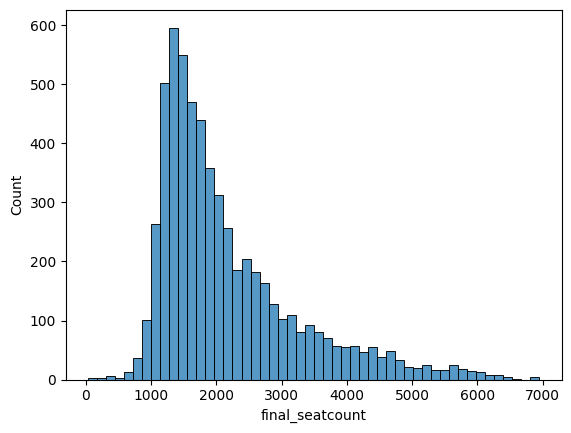

In [86]:
import seaborn as sns
sns.histplot(submission['final_seatcount'], bins=50)


In [87]:
submission['final_seatcount'] = submission['final_seatcount'].clip(lower=0)


In [88]:
print(submission)

             route_key  final_seatcount
0     2025-02-11_46_45      3534.422500
1     2025-01-20_17_23      1572.578569
2     2025-01-08_02_14      1205.439129
3     2025-01-08_08_47       999.434473
4     2025-01-08_09_46      2827.777756
...                ...              ...
5895  2025-01-23_46_48      3986.134720
5896  2025-02-21_46_09      5614.435432
5897  2025-01-17_32_19      2315.931507
5898  2025-01-24_45_03      1316.537683
5899  2025-01-27_32_19      2380.468330

[5900 rows x 2 columns]


In [89]:
submission.to_csv("/content/drive/MyDrive/Booking_hackathon/outputs/final_submission_1.csv", index=False)

ANOTHER FOR EXXAMPLE TAKEN BELOW THESE CODES ARE NOT REQUIRED